## 買入持有策略回測範例

In [5]:
from rqalpha.api import *
from rqalpha import run_func

In [8]:
config = {
  "base": {
    "start_date": "2010-01-01",
    "end_date": "2017-05-05",
    "benchmark": "000001.XSHG",
    "accounts": {
        "stock": 100000
    }
  },
  "extra": {
    "log_level": "info",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True,
    },
  }
}

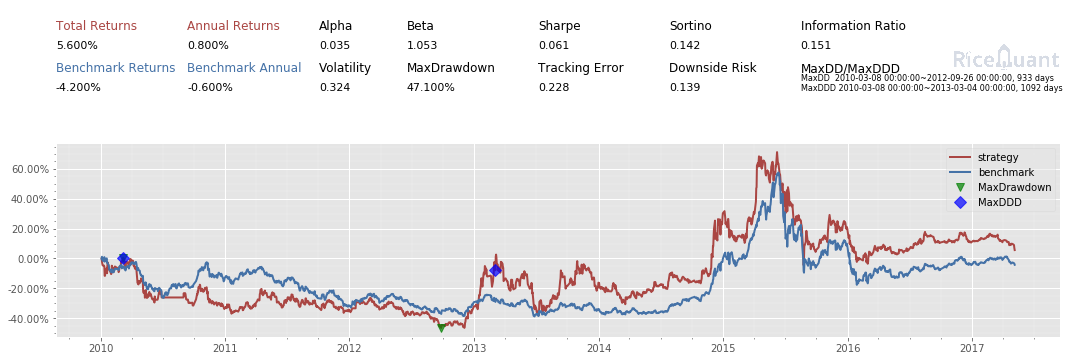

In [9]:
# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    logger.info("init")
    context.s1 = "000001.XSHE"
    update_universe(context.s1)
    # 是否已发送了order
    context.fired = False
    context.cnt = 1


def before_trading(context, bar_dict):
    logger.info("Before Trading", context.cnt)
    context.cnt += 1


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    context.cnt += 1
    logger.info("handle_bar", context.cnt)
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！
    if not context.fired:
        # order_percent并且传入1代表买入该股票并且使其占有投资组合的100%
        order_percent(context.s1, 1)
        context.fired = True

results = run_func(init=init, handle_bar=handle_bar, config=config)

## Golden Cross 策略回測範例

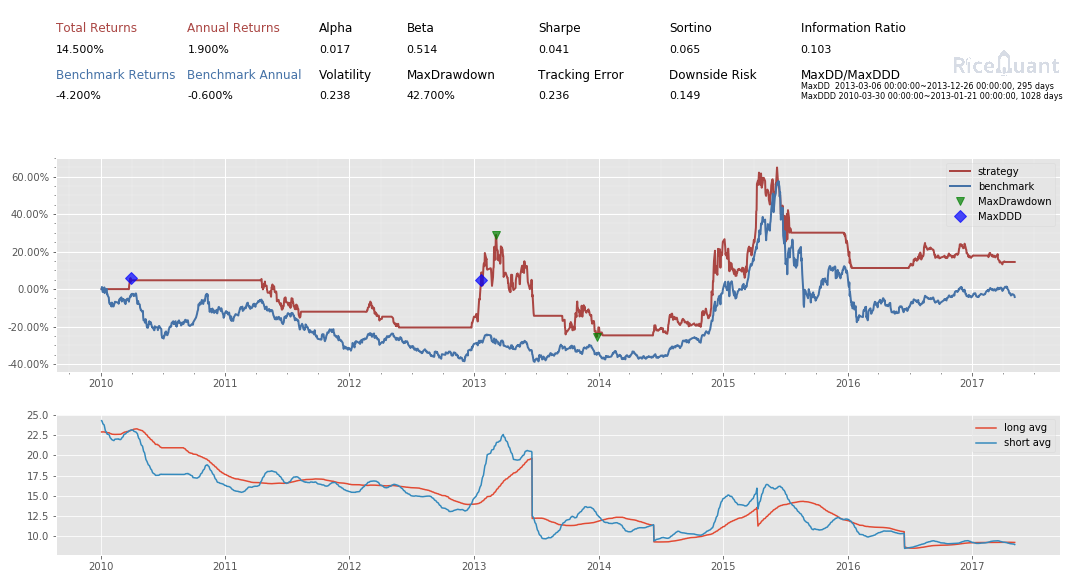

In [11]:
import talib


# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    context.s1 = "000001.XSHE"

    # 设置这个策略当中会用到的参数，在策略中可以随时调用，这个策略使用长短均线，我们在这里设定长线和短线的区间，在调试寻找最佳区间的时候只需要在这里进行数值改动
    context.SHORTPERIOD = 20
    context.LONGPERIOD = 120


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！

    # 因为策略需要用到均线，所以需要读取历史数据
    prices = history_bars(context.s1, context.LONGPERIOD+1, '1d', 'close')

    # 使用talib计算长短两根均线，均线以array的格式表达
    short_avg = talib.SMA(prices, context.SHORTPERIOD)
    long_avg = talib.SMA(prices, context.LONGPERIOD)

    plot("short avg", short_avg[-1])
    plot("long avg", long_avg[-1])

    # 计算现在portfolio中股票的仓位
    cur_position = context.portfolio.positions[context.s1].quantity
    # 计算现在portfolio中的现金可以购买多少股票
    shares = context.portfolio.cash/bar_dict[context.s1].close

    # 如果短均线从上往下跌破长均线，也就是在目前的bar短线平均值低于长线平均值，而上一个bar的短线平均值高于长线平均值
    if short_avg[-1] - long_avg[-1] < 0 and short_avg[-2] - long_avg[-2] > 0 and cur_position > 0:
        # 进行清仓
        order_target_value(context.s1, 0)

    # 如果短均线从下往上突破长均线，为入场信号
    if short_avg[-1] - long_avg[-1] > 0 and short_avg[-2] - long_avg[-2] < 0:
        # 满仓入股
        order_shares(context.s1, shares)
        
results = run_func(init=init, handle_bar=handle_bar, config=config)

## 單股 MACD 策略回測範例

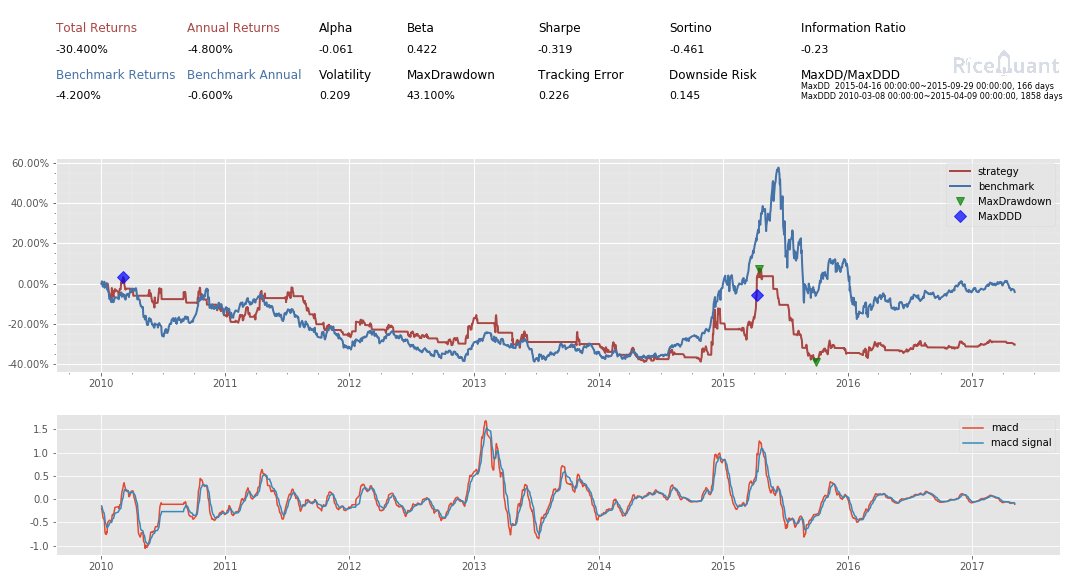

In [12]:
import talib


# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    context.s1 = "000001.XSHE"

    # 使用MACD需要设置长短均线和macd平均线的参数
    context.SHORTPERIOD = 12
    context.LONGPERIOD = 26
    context.SMOOTHPERIOD = 9
    context.OBSERVATION = 100


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！

    # 读取历史数据，使用sma方式计算均线准确度和数据长度无关，但是在使用ema方式计算均线时建议将历史数据窗口适当放大，结果会更加准确
    prices = history_bars(context.s1, context.OBSERVATION,'1d','close')

    # 用Talib计算MACD取值，得到三个时间序列数组，分别为macd, signal 和 hist
    macd, signal, hist = talib.MACD(prices, context.SHORTPERIOD,
                                    context.LONGPERIOD, context.SMOOTHPERIOD)

    plot("macd", macd[-1])
    plot("macd signal", signal[-1])

    # macd 是长短均线的差值，signal是macd的均线，使用macd策略有几种不同的方法，我们这里采用macd线突破signal线的判断方法

    # 如果macd从上往下跌破macd_signal

    if macd[-1] - signal[-1] < 0 and macd[-2] - signal[-2] > 0:
        # 计算现在portfolio中股票的仓位
        curPosition = context.portfolio.positions[context.s1].quantity
        #进行清仓
        if curPosition > 0:
            order_target_value(context.s1, 0)

    # 如果短均线从下往上突破长均线，为入场信号
    if macd[-1] - signal[-1] > 0 and macd[-2] - signal[-2] < 0:
        # 满仓入股
        order_target_percent(context.s1, 1)
        
results = run_func(init=init, handle_bar=handle_bar, config=config)

## 多股 RSI 策略回測範例

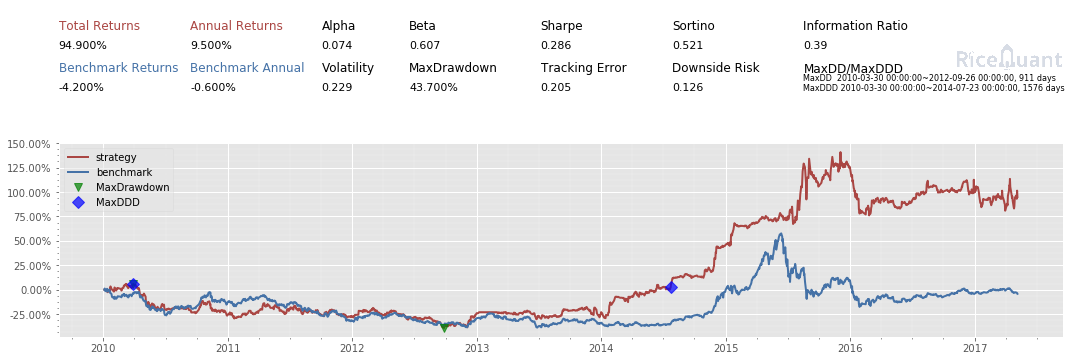

In [13]:
import talib


# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):

    # 选择我们感兴趣的股票
    context.s1 = "000001.XSHE"
    context.s2 = "601988.XSHG"
    context.s3 = "000068.XSHE"
    context.stocks = [context.s1, context.s2, context.s3]

    context.TIME_PERIOD = 14
    context.HIGH_RSI = 85
    context.LOW_RSI = 30
    context.ORDER_PERCENT = 0.3


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！

    # 对我们选中的股票集合进行loop，运算每一只股票的RSI数值
    for stock in context.stocks:
        # 读取历史数据
        prices = history_bars(stock, context.TIME_PERIOD+1, '1d', 'close')

        # 用Talib计算RSI值
        rsi_data = talib.RSI(prices, timeperiod=context.TIME_PERIOD)[-1]

        cur_position = context.portfolio.positions[stock].quantity
        # 用剩余现金的30%来购买新的股票
        target_available_cash = context.portfolio.cash * context.ORDER_PERCENT

        # 当RSI大于设置的上限阀值，清仓该股票
        if rsi_data > context.HIGH_RSI and cur_position > 0:
            order_target_value(stock, 0)

        # 当RSI小于设置的下限阀值，用剩余cash的一定比例补仓该股
        if rsi_data < context.LOW_RSI:
            logger.info("target available cash caled: " + str(target_available_cash))
            # 如果剩余的现金不够一手 - 100shares，那么会被ricequant 的order management system reject掉
            order_value(stock, target_available_cash)
            
results = run_func(init=init, handle_bar=handle_bar, config=config)

## 海龜交易系統回測範例

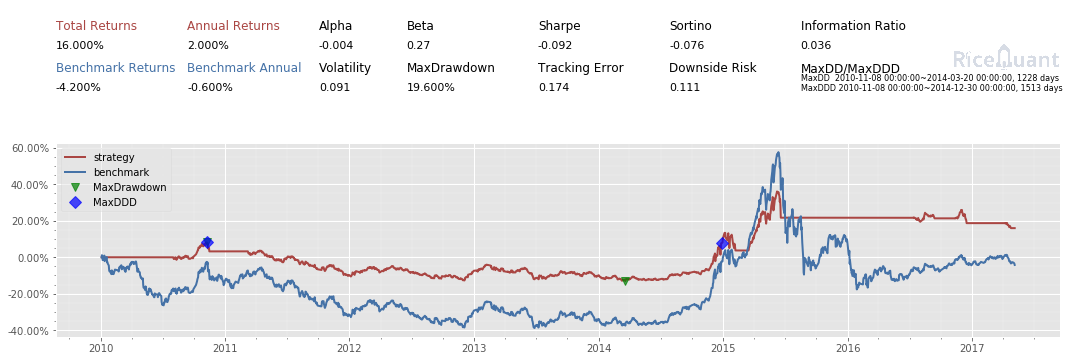

In [14]:
import numpy as np
import talib
import math


def get_extreme(array_high_price_result, array_low_price_result):
    np_array_high_price_result = np.array(array_high_price_result[:-1])
    np_array_low_price_result = np.array(array_low_price_result[:-1])
    max_result = np_array_high_price_result.max()
    min_result = np_array_low_price_result.min()
    return [max_result, min_result]


def  get_atr_and_unit( atr_array_result,  atr_length_result, portfolio_value_result):
    atr =  atr_array_result[ atr_length_result-1]
    unit = math.floor(portfolio_value_result * .01 / atr)
    return [atr, unit]


def get_stop_price(first_open_price_result, units_hold_result, atr_result):
    stop_price = first_open_price_result - 2 * atr_result \
                 + (units_hold_result - 1) * 0.5 * atr_result
    return stop_price


def init(context):
    context.trade_day_num = 0
    context.unit = 0
    context.atr = 0
    context.trading_signal = 'start'
    context.pre_trading_signal = ''
    context.units_hold_max = 4
    context.units_hold = 0
    context.quantity = 0
    context.max_add = 0
    context.first_open_price = 0
    context.s = '000300.XSHG'
    context.open_observe_time = 55
    context.close_observe_time = 20
    context.atr_time = 20


def handle_bar(context, bar_dict):
    portfolio_value = context.portfolio.portfolio_value
    high_price = history_bars(context.s, context.open_observe_time+1, '1d', 'high')
    low_price_for_atr = history_bars(context.s, context.open_observe_time+1, '1d', 'low')
    low_price_for_extreme = history_bars(context.s, context.close_observe_time+1, '1d', 'low')
    close_price = history_bars(context.s, context.open_observe_time+2, '1d', 'close')
    close_price_for_atr = close_price[:-1]

    atr_array = talib.ATR(high_price, low_price_for_atr, close_price_for_atr, timeperiod=context.atr_time)

    maxx = get_extreme(high_price, low_price_for_extreme)[0]
    minn = get_extreme(high_price, low_price_for_extreme)[1]
    atr = atr_array[-2]

    if context.trading_signal != 'start':
        if context.units_hold != 0:
            context.max_add += 0.5 * get_atr_and_unit(atr_array, atr_array.size, portfolio_value)[0]
    else:
        context.max_add = bar_dict[context.s].last

    cur_position = context.portfolio.positions[context.s].quantity
    available_cash = context.portfolio.cash
    market_value = context.portfolio.market_value

    if (cur_position > 0 and
            bar_dict[context.s].last < get_stop_price(context.first_open_price, context.units_hold, atr)):
        context.trading_signal = 'stop'
    else:
        if cur_position > 0 and bar_dict[context.s].last < minn:
            context.trading_signal = 'exit'
        else:
            if (bar_dict[context.s].last > context.max_add and context.units_hold != 0 and
                    context.units_hold < context.units_hold_max and
                    available_cash > bar_dict[context.s].last*context.unit):
                context.trading_signal = 'entry_add'
            else:
                if bar_dict[context.s].last > maxx and context.units_hold == 0:
                    context.max_add = bar_dict[context.s].last
                    context.trading_signal = 'entry'

    atr = get_atr_and_unit(atr_array, atr_array.size, portfolio_value)[0]
    if context.trade_day_num % 5 == 0:
        context.unit = get_atr_and_unit(atr_array, atr_array.size, portfolio_value)[1]
    context.trade_day_num += 1
    context.quantity = context.unit

    if (context.trading_signal != context.pre_trading_signal or
            (context.units_hold < context.units_hold_max and context.units_hold > 1) or
            context.trading_signal == 'stop'):
        if context.trading_signal == 'entry':
            context.quantity = context.unit
            if available_cash > bar_dict[context.s].last*context.quantity:
                order_shares(context.s, context.quantity)
                context.first_open_price = bar_dict[context.s].last
                context.units_hold = 1

        if context.trading_signal == 'entry_add':
            context.quantity = context.unit
            order_shares(context.s, context.quantity)
            context.units_hold += 1

        if context.trading_signal == 'stop':
            if context.units_hold > 0:
                order_shares(context.s, -context.quantity)
                context.units_hold -= 1

        if context.trading_signal == 'exit':
            if cur_position > 0:
                order_shares(context.s, -cur_position)
                context.units_hold = 0

    context.pre_trading_signal = context.trading_signal
    
results = run_func(init=init, handle_bar=handle_bar, config=config)    